In [303]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from meteostat import Point, Daily, units
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

In [304]:
# Set time period
N = 75
# end = datetime.now()
end = datetime(2023, 1,1)
start = datetime(end.year - N, end.month, end.day)

# Create Point for NYC
nyc = Point(40.7789, -73.9692, 3.0)

# fetch data series
data = Daily(nyc, start, end)
data = data.convert(units.imperial)
data = data.fetch()

In [305]:
data["year"], data["month"], data["day"] = (
    data.index.year,
    data.index.month,
    data.index.day,
)

In [306]:
daily_max_avg = pd.DataFrame(data.tmax.groupby(by=[data.month, data.day]).mean())
daily_max_max = pd.DataFrame(data.tmax.groupby(by=[data.month, data.day]).max())

In [307]:
daily_max_avg["time"] = daily_max_avg.index.values
daily_max_avg


tmax      time
month day                     
1     1    41.335526    (1, 1)
      2    40.806667    (1, 2)
      3    40.106667    (1, 3)
      4    40.618667    (1, 4)
      5    39.446667    (1, 5)
...              ...       ...
12    27   39.636000  (12, 27)
      28   42.657333  (12, 28)
      29   42.064000  (12, 29)
      30   40.800000  (12, 30)
      31   41.341333  (12, 31)

[366 rows x 2 columns]

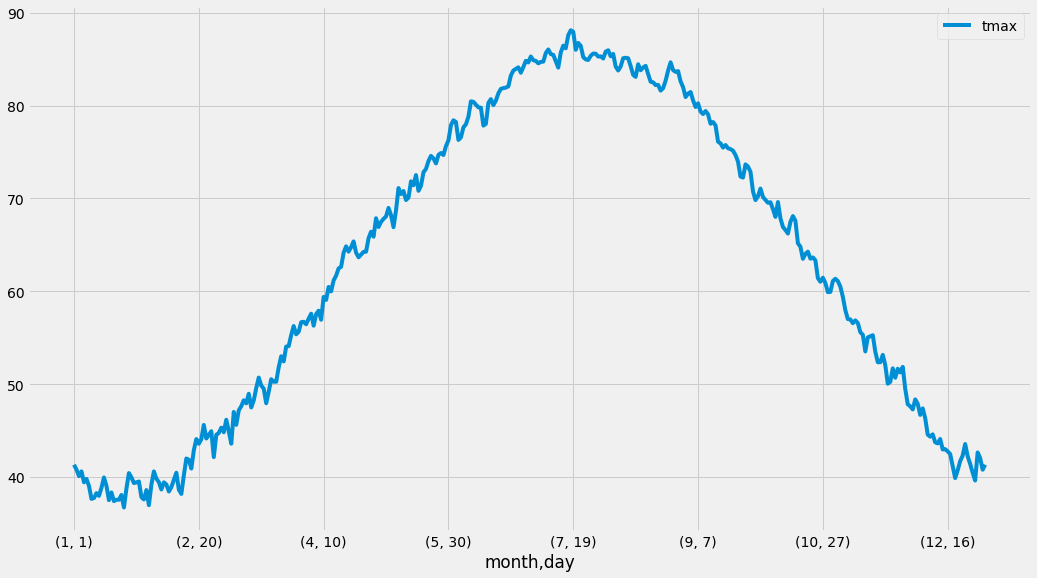

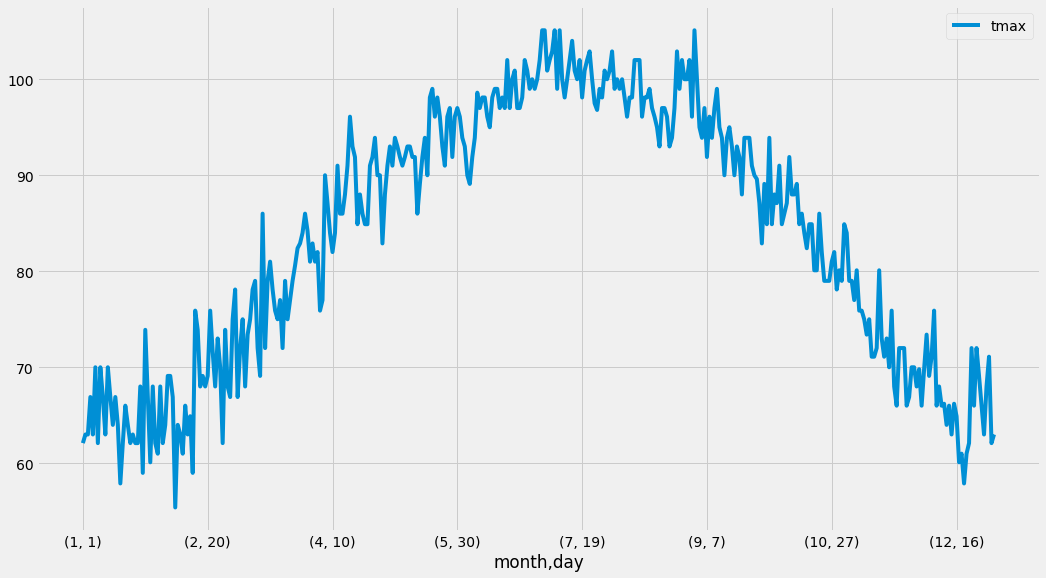

In [308]:
daily_max_avg.plot()
daily_max_max.plot()
plt.show()

In [309]:
# check if today hotter than average
today = end.strftime("%Y-%m-%d")
Month, Day, Year = end.month, end.day, end.year

todays_high = data.tmax.loc[today]
todays_avg_high = daily_max_avg.tmax.loc[(Month, Day)]
todays_max_high = daily_max_max.tmax.loc[(Month, Day)]


In [310]:
if todays_high > todays_avg_high:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F hotter than today's {N}-year average."
    )
else:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F cooler than today's {N}-year average."
    )
print(f"The {N}-year historical high for today is {todays_max_high:.1f}°F")

The high today in New York is 53.6°F, 12.3°F hotter than today's 75-year average.
The 75-year historical high for today is 62.1°F


In [311]:
# # scatter plot of today's temps
pd.options.mode.chained_assignment = None
daily_hist_series = data[(data["month"] == Month) & (data["day"] == Day)]
daily_hist_series["most_recent"] = np.where(
    daily_hist_series["year"] == daily_hist_series["year"].max(), 1, 0
)


In [312]:
daily_hist_series

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,year,month,day,most_recent
time,,,,,,,,,,,,,,
1948-01-01,NaN,28.0,32.0,0.902,14.016,NaN,NaN,NaN,NaN,NaN,1948,1,1,0
1949-01-01,NaN,24.1,30.9,0.079,4.016,NaN,NaN,NaN,NaN,NaN,1949,1,1,0
1950-01-01,NaN,28.0,42.1,0.000,0.000,NaN,NaN,NaN,NaN,NaN,1950,1,1,0
1951-01-01,NaN,26.1,39.9,0.000,0.000,NaN,NaN,NaN,NaN,NaN,1951,1,1,0
1952-01-01,NaN,43.0,50.0,0.000,0.000,NaN,NaN,NaN,NaN,NaN,1952,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-01,51.1,43.0,57.0,0.240,0.000,285.0,8.1,NaN,1010.9,NaN,2019,1,1,0
2020-01-01,38.5,35.1,41.0,0.000,0.000,273.0,10.8,NaN,1008.2,NaN,2020,1,1,0
2021-01-01,36.5,33.8,39.2,0.575,0.000,20.0,8.2,NaN,1029.4,NaN,2021,1,1,0


In [397]:
# add N year spline fit, with confidence bars
x, y = daily_hist_series["year"].values.reshape(-1, 1), daily_hist_series[
    ["tmax"]
].values.reshape(-1)
model = make_pipeline(SplineTransformer(n_knots=4, degree=2), Ridge(alpha=1e-3))
model.fit(x, y)

y_true_long = np.linspace(y.min(), y.max(), 500)
x_plot = np.linspace(Year - N, Year, 500).reshape(-1, 1)
y_pred = model.predict(x).reshape(-1)
y_plot = model.predict(x_plot)

upper_ci = y_plot + (1.96 * np.std(y)/np.sqrt(N + 1))
lower_ci = y_plot - (1.96 * np.std(y)/np.sqrt(N + 1))

In [405]:
residuals = (y_true_long - y_plot).reshape(-1)
res_sd = np.std(residuals)
leverage = np.diagonal(x_plot.dot(np.linalg.inv(x_plot.T.dot(x_plot)).dot(x_plot.T)))
jackknife_se = residuals / (res_sd * np.sqrt(1 - leverage))

upper_jk_ci = y_plot + (1.96 * jackknife_se) 
lower_jk_ci = y_plot - (1.96 * jackknife_se)

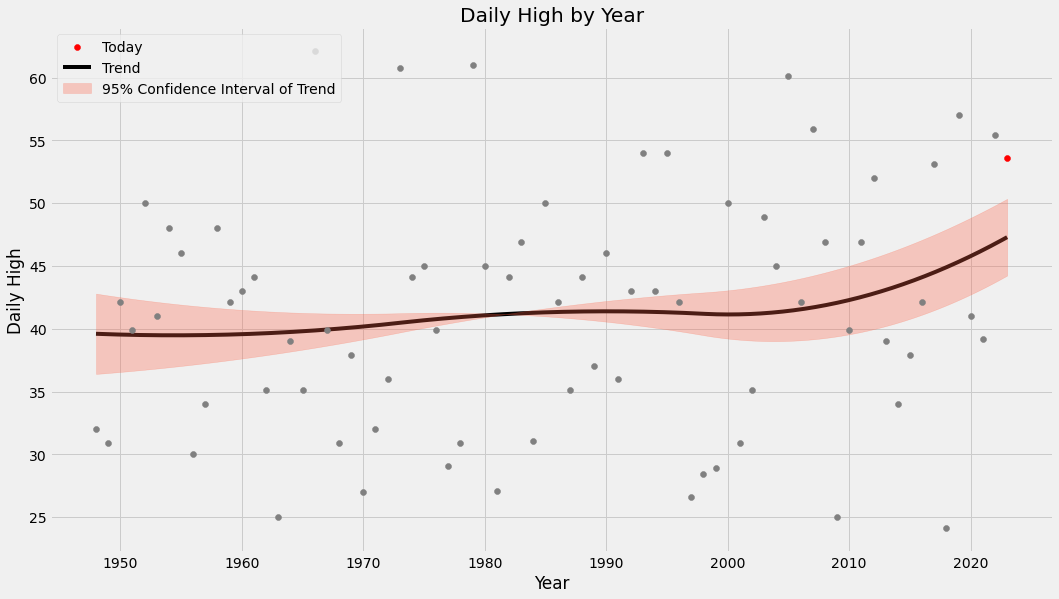

In [408]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (16, 9)

plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 0],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 0],
    color="gray",
    zorder=2,
)
plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 1],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 1],
    color="red",
    label="Today",
    zorder=3,
)

plt.plot(x_plot, y_plot, color="Black", zorder=1, label="Trend")

plt.fill_between(
    x_plot.reshape(-1),
    upper_jk_ci,
    lower_jk_ci,
    color="tomato",
    zorder=1,
    alpha=0.3,
    label="95% Confidence Interval of Trend",
)


plt.xlabel("Year")
plt.ylabel("Daily High")
plt.title("Daily High on by Year")
plt.legend(loc="upper left")
plt.show()

In [407]:
# fit <- smooth.spline(data$x, data$y)      # smooth.spline fit
#   res <- (fit$yin - fit$y)/(1-fit$lev)      # jackknife residuals
# sigma <- sqrt(var(res))                     # estimate sd

# upper <- fit$y + 2.0*sigma*sqrt(fit$lev)   # upper 95% conf. band
# lower <- fit$y - 2.0*sigma*sqrt(fit$lev)   # lower 95% conf. band
# matplot(fit$x, cbind(upper, fit$y, lower), type="plp", pch=".")